In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Homogeneous Background Freezing for Droplet Feeezing Experiments

A common way to assess IN ability of field or laboratory samples is by subdividing the samples into small portions/droplets and gradually lowering the temperature from 0$^o$C to some value near the homogeneous limit of -38$^o$C as reported in the literature [][][]. The presence of an INP in an individual droplet is generally rare, either from observations of cloud water samples or experimental design (dilution series of laboratory-prepared samples, etc.), and thus are assumed to be randomly distributed throughout the sampled droplets. Droplets containing INPs should freeze at higher temperatures than pure samples or those containing INPs with lower activation temperatures. The statistical framework for inferring INP concentration from a DFE is developed in Vali (1971,2018)

<img src='C:/Users/Owner/Downloads/Water.jpg'>

While both homogeneous and heterogeneous nucleation of ice in water are not fully understood, classical nucleation theory CNT can be used to model the behavior of supercooled droplets and calculate the homogenous background freezing. For homogeneous nucleation, characteristic freezing times are a function of both temperature and droplet size. The following derivation is based on Wang. 2013:

The basic assumption of classical nucleation theory is that the formation of ice in water is similar to that of nucleation of liquid droplets from the gas phase. Treating a droplet as a cannonical ensemble of pure water molecules with properties $N$, $V$, $T$ representing the number of molecules in the system, the macroscopic volume of the droplet (usually fixed for a freezing experiment), and temperature (the manipulated variable of a DFE) respectively. 

With decreasing temperature, water molecules are thought to form small clusters with quasi-ice properties called *i-mers* or *ice embyros*. A reference free energy $\Delta F_0 = 0$ is chosen to be that of a monomer (single water molecule in liquid phase at temperature $T$). Clusters are assumed to be approximately spherical in shape, so that the free energy of formation can be calculated by:

$$
\Delta F = -\frac{4\pi a_i^3}{3\nu_{mole}}k_bTln(S) + 4\pi a^2 \sigma \tag{Wang eq. 7.19}
$$

Where $a_i$ is the radius of the i-mer ($m$), $\nu_{mole}$ is the volume of a single water molecule ($m^3$), $k_b$ is Boltzmann's constant ($J/K$), $S$ is the saturation ratio of the droplet (dimensionless, function of temperature), and $\sigma$ is the energy of formation of the ice/water interface ($J/m^2$). 

At supercooled temperatures ($T < 273K$), the water molecules prefer to exist as bulk ice, but there is an energetic cost of constructing the ice-water interface separating the two states. As such, phase transition will only be energetically favorable if there already exists an embryo with a large volume compared to it's surface. Since the ratio $\frac{SA}{V}$ of a sphere (true of most shapes) decreases with increasing size, we can define a *critical embryo radius,* $a_g$ above which adding any additional molecules to the embryo will decrease the free energy of the system, leading to all molecules undergoing a spontaneous phase transition and the whole droplet freezes very rapidly. 

In [2]:
## Define constants

NA = 6.02 * 10 ** 23  # Avagadros number
kb = 1.3806503 * 10 ** -23  # m2 kg s-2 K-1 boltzmann const
rho_w = 1000  # kg/m3 bulk density of water
rho_i = 920  # kg/m3 bulk density of ice
Mw = 18.02 / 1000  # kg/mol molar mass of H20
v_mole_w = Mw / (rho_w * NA)  # volume of a single water molecule
v_mole_i = Mw / (rho_i * NA)  # volume of a single ice molecule

$\sigma_{i,w}$ and $S$ can be obtained using the following parameterizations over the temperature range relevant to ice nucleation (find whose parameterizations these are):

$
\sigma_{i,w} = 189.081 + 13.1625T + 0.3469T^2+ (3.12\cdot10^{−3})T^3
$

$
ln(e_{s,i}) = 9.550426−(5723.265T^{−1}) + 3.53068  ln(T)−0.00728332T
$

$
ln(e_{s,w}) = 54.842763−6763.22T^{−1} − 4.21ln(T) + 0.000367T + tanh(0.0415(T−218.8))(53.878−1331.22T^{−1} − 9.44523  ln(T) + 0.014025T)
$

where $S$ is defined as $e_{s,w}/e_{s,i}$

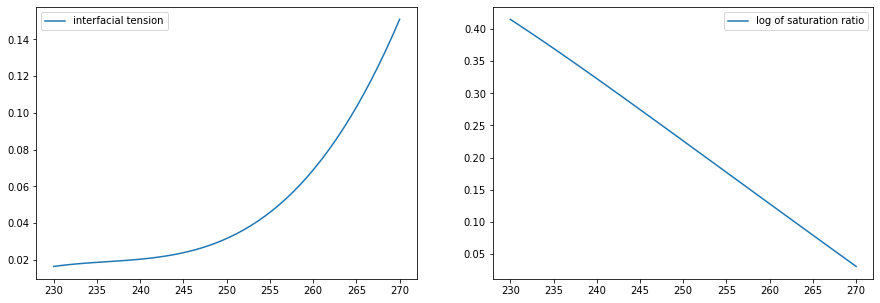

In [3]:
def sig_iw(T):
    """
    calculate surface tension of an ice-water interface given temperature (kelvin)
    """
    T_c = T - 273.15
    sig = (
        189.081 + 13.1625 * T_c + 0.3469 * T_c ** 2 + 3.12 * 10 ** -3 * T_c ** 3
    )  # 10^-3 N/m
    sig *= 10 ** -3  # conversion to SI units J/m2
    return sig


def S_iw(T):
    """
    calculates the saturation ratio of an ice-water interface given temperature (kelvin)
    """
    e_si = np.exp(
        9.550426 - 5723.265 * T ** -1 + 3.53068 * np.log(T) - 0.00728332 * T
    )  # Pa
    e_sw = np.exp(
        54.842763
        - 6763.22 * T ** -1
        - 4.21 * np.log(T)
        + 0.000367 * T
        + np.tanh(0.0415 * (T - 218.8))
        * (53.878 - 1331.22 * T ** -1 - 9.44523 * np.log(T) + 0.014025 * T)
    )  # Pa
    return e_sw / e_si

temps = np.linspace(230,270,50)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(temps,sig_iw(temps),label='interfacial tension')
ax[1].plot(temps,np.log(S_iw(temps)),label='log of saturation ratio')
ax[0].legend()
ax[1].legend();

We can plot $\Delta F$ as a function of embryo radius for a variety of temperatures and observe the critical radius at the maxima of each curve $\Delta F(T)$, as well as the number of molecules required for a critical embryo at a given temperature.


To calculate the critical radius, differentiate $\Delta F$ and set the derivative equal to zero (find the function maxima):

$$
\frac{\partial\Delta F}{\partial a} = -\frac{4\pi 3a_i^2}{3\nu_{mole}}k_bTln(S) + 4\pi(2) a \sigma = 0
$$

$$
a_g = \frac{2 \sigma_{i,w}\nu_{mole}}{k_bTln(S)}
$$


In [4]:
def delF(T, a):
    """
    calculates the free energy of spherical ice i-mer formation for temp T and i-mer radius a
    """
    F = (-(4 / 3) * np.pi * a ** 3 * kb * T * np.log(S_iw(T)) / v_mole_i) + (
        4 * np.pi * a ** 2 * sig_iw(T)  # wang eq 7.20
    )
    return F


def a_g(T):
    """
    calculates the critical radius of an ice germ given temperature
    """
    a_g = (2 * sig_iw(T) * v_mole_i) / (kb * T * np.log(S_iw(T)))
    return a_g


def imers(T):
    """
    calculate how many molecules must be involved in critical cluster
    """
    nmcls = 4 / 3 * np.pi * a_g(T) ** 3 / v_mole_i
    return nmcls

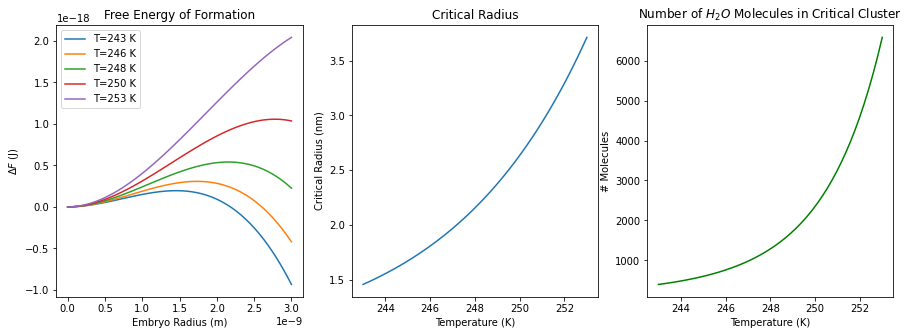

In [5]:
a = np.linspace(0,3,50) *1e-9
temps = np.linspace(243,253,5) # K
fig, ax = plt.subplots(1,3,figsize=(15,5))
for temp in temps:
    ax[0].plot(a,delF(temp,a), label=f'T={round(temp)} K')
    
ax[0].legend()
ax[0].set_xlabel('Embryo Radius (m)')
ax[0].set_ylabel('$\Delta F$ (J)')
ax[0].set_title('Free Energy of Formation')

temps = np.linspace(243,253,50) # K
ax[1].plot(temps,a_g(temps)*10**9)
ax[1].set_xlabel('Temperature (K)')
ax[1].set_ylabel('Critical Radius (nm)')
ax[1].set_title('Critical Radius')

ax[2].plot(temps,imers(temps), color='g')
ax[2].set_xlabel('Temperature (K)')
ax[2].set_ylabel('# Molecules')
ax[2].set_title('Number of $H_2O$ Molecules in Critical Cluster');

Looking at these plots, we observe that:

  1) the energy barrier preventing spontaneous transition to the ice phase gets smaller with decreasing temperature

  2) the critical radius, and thus the number of individual molecules required for a critical ice embryo also decreases with decreasing temperature
  
From intuition, we might guess that it is far more likely to find a cluster of ~100 molecules than one consisting of several thousand, and that the larger clusters would be less stable over time, if they come to exist at all. We can verify this by calculating the probability of observing an embryo of a given size by describing the system with a *Boltzmann distribution*, which assigns probabilities to each energetic state the system may occupy based on the temperature.

$$
N_i = N_{sat,i}exp\left(\frac{-\Delta F_i}{k_bT}\right) \tag{Wang 7.1}
$$

Where $N_i$ is the number of embryos in state $i$, $N_{sat,i}$ is the total number of molecules in the system, and $\Delta F_i$ is the free energy of formation for each i-mer, given by eq 7.19

*Note: I'm pretty sure this is wrong on two counts: 1) Its an un-nomalized boltzmann distribution with no partition function, 2) this is the number of molecules that are components of i-mers, not the number of i-mers. The embryos should not all exist at once..right? Further investigation required, maybe I misunderstood something in the textbook...*

Anyways, lets plot the number of critical embryos per volume of water at any given instant in time, assuming the book is correct:

$$
N_{i,critical} = N_{sat,i}exp\left(\frac{-\Delta F_{critical}}{k_bT}\right)
$$

In [6]:
def Ni(T, a, N_sati):  # /m3
    """
    calculates the number of ice i-mers of desired radius 'a', given temp T
    """
    Ni = N_sati * np.exp(-delF(T, a) / (kb * T))  # wang eq 7.1
    return Ni


def N_crit(T, N_sati):
    """
    finds the number of embryos at the critical radius
    """
    N_crit = Ni(T,a_g(T),N_sati)
    return N_crit
    
dropvol = 1 # m3
N_sati =  dropvol / v_mole_w # number of molecules

# observe scary normalization problem: given one molecule the distribution outputs
# 10^87 molecules in critical state. yikes.
N_crit(210, 1)

2.389763352057937e+87

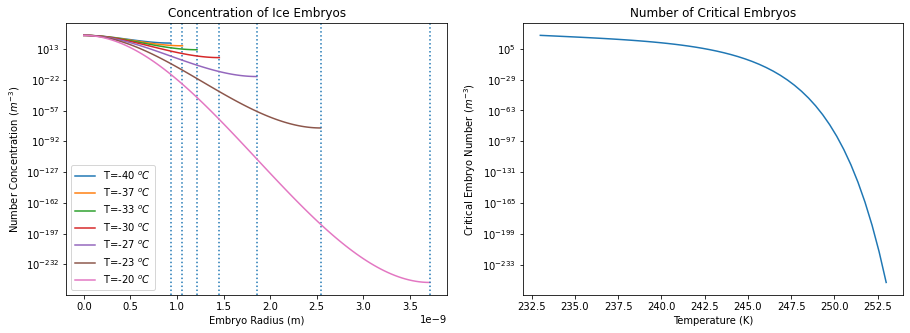

In [7]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

# plot concentration as a function of radius
temps = np.linspace(233,253,7)
for temp in temps:
    a = np.linspace(0, a_g(temp), 100)  # only plot out to critical radius

    the_temp = round(temp)
    ax[0].plot(a, Ni(temp, a, N_sati), label=f"T={the_temp-273} $^oC$")
    ax[0].axvline(x=a_g(temp), ls=":")  # draw the critical radius at T
ax[0].legend()
ax[0].set_yscale("log")
ax[0].set_title("Concentration of Ice Embryos")
ax[0].set_xlabel("Embryo Radius (m)")
ax[0].set_ylabel("Number Concentration ($m^{-3})$")

# plot critical concentration as a function of temperature
temps = np.linspace(233,253,50)
ncrit = np.empty(len(temps))
for i in range(len(temps)):
    ncrit[i] = N_crit(temps[i],N_sati)

ax[1].plot(temps,ncrit)
ax[1].set_yscale('log')
ax[1].set_xlabel('Temperature (K)')
ax[1].set_ylabel('Critical Embryo Number ($m^{-3}$)')
ax[1].set_title('Number of Critical Embryos');

These functions span an incredible range over the temperature domain relevant for atmospheric ice nucleation. Depending on the degree of supercooling, there can be anywhere from $10^{19}$ critical embryos to $10^{-230}$ in a cubic meter of liquid water. Note that here, fractional numbers of critical embryos are not unphysical results, they just represent extremely unlikely states for the system to occupy. In principle, every possible state can be found given a large enough sample of supercooled water. *Extremely unlikely* is quite an understatement; to put this in perspective at $-20^oC$, one would require a water sample (assuming it is pure water) many times larger than the known universe. (find more examples like this, they are fun)

Let's apply this to individual droplets as one might find in a cloud or freezing experiment, and try to determine the likelihood of a droplet spontaneously freezing over a given period of time. Freezing rate can be determined as follows:

1) assume that all samples which contain at least one critical embryo spontaneously freeze

2) determine the rate at which critical embryos manifest within a sample using the equation:

$$
J = K \cdot N_{i,critical}
$$

Where $K$ ($\approx 0.3s^{-1}$) is a coefficient capturing the speed at which water molecules jump from state to state, and $N_{i,critical}$ is the number of critical embryos in the sample as calculated above. We expect that samples with large numbers (ie one or greater) of critical embryos will freeze very quickly, and those will less will take longer, with warm samples yielding very long freezing times. The mathematical framework is very similar to that of radioactive decay, with the number of unfrozen samples decreasing as the exponent of time, scaled by a time constant dependent on the system (in this case, likelihood of a critical embryo at temp $T$).

$$
N_u=N_0e^{−Jt}
$$

$N_0$ is the starting number of droplets, $N_u$ is the number of unfrozen droplets at time $t$, which can also be expressed as $N_0 - N_{frz}$, so the number of droplets frozen at $t$ is:

$$
N_{frz} = N_0(1-e^{-Jt})
$$

We can also re-arrange for the time where some fraction $\frac{N_u}{N_0}$ of droplets remain unfrozen:

$$
t = \frac{-ln(N_u/N_0)}{J}
$$

Let's apply this to a population of 1000 cloud droplets with radii $10\mu m$, and a corresponding volume of ~4pL, plotting the number of frozen droplets with time and the time it takes for half the droplets to freeze:

In [8]:
def nfrz(N0, dropvol, T, t):
    """
    calculates the number of frozen droplets given starting number of drops, temperature, time
    """
    N_sati = dropvol / v_mole_w
    ncrit = N_crit(T, N_sati)
    J = 0.3 * ncrit  # critical embryos/s
    N_frz = N0 * (1 - np.exp(-J * t))
    return N_frz


def t_50(dropvol, T):
    N_sati = dropvol / v_mole_w
    ncrit = N_crit(T, N_sati)
    J = 0.3 * ncrit  # critical embryos/s
    t_50 = -np.log(0.5) / J
    return t_50

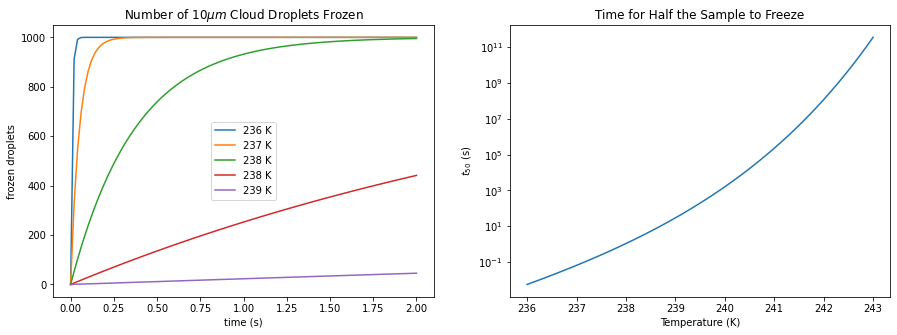

In [9]:
rad = 10e-6  # m
vol = 4 / 3 * np.pi * rad ** 3
temps = np.linspace(236, 239, 5)
time = np.linspace(0, 2, 100)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for temp in temps:
    lab = f"{round(temp)} K"
    ax[0].plot(time, nfrz(1000, vol, temp, time), label=lab)
ax[0].legend()
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("frozen droplets")
ax[0].set_title("Number of 10$\mu m$ Cloud Droplets Frozen")
temps = np.linspace(236, 243, 50)
ax[1].plot(temps, t_50(vol, temps))
ax[1].set_yscale("log")
ax[1].set_xlabel("Temperature (K)")
ax[1].set_ylabel("$t_{50}$ (s)")
ax[1].set_title("Time for Half the Sample to Freeze");

Again, over the relatively small range of temperatures considered, we see an incredible change in behavior. At $236K$ ($-37^oC$), the characteristic freezing time is 5 milleseconds, and at $243K$ ($-30^oC$) it is over 10,000 years!

Even though we've shown that spontaneous freezing becomes very p... this is important to droplet freezing experiments.

Take a typical experiment consisting of 288 wells of $10\mu L$ volume, with the temperature steadily decreasing from $0^oC$ at a rate of 1$^o$C/min. I'm too tired to solve this analytically but can probably swing it numerically:

$$
T(t) = 273.15 - \frac{1K}{60s}t
$$

At each timestep, update $N_0$ by subtracting the frozen droplets that occurred in the previous timestep. then add the total frozen droplets to some vector ```N_frztotal``` .. this will work

In [10]:
time = np.linspace(0, 2000, 2001)  # just over half an hour, one second resolution
n_frzinst = np.empty_like(time) # create empty vectors to hold frozen droplet counts. note 
n_frztotal = np.empty_like(time) # this is terribly done and not computationally stable. fix in v2

#rad = 10e-7  # m
#wellvol = 4 / 3 * np.pi * rad ** 3

wellvol = 10e-6  # 10 microliter sample wells

n_0 = 288
for t in range(len(time)):
    temp = 273.15 - 1 / 60 * time[t]
    n_frzinst[t] = nfrz(n_0, wellvol, temp, time[t])
    n_frztotal[t] = n_frztotal[t - 1] + n_frzinst[t]
    n_0 -= n_frzinst[t]

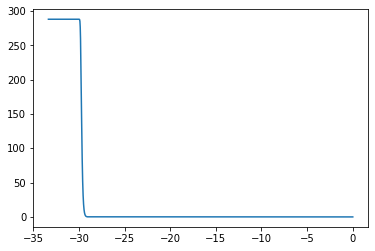

In [11]:
temp = -1/60*time
plt.plot(temp,n_frztotal);

This works fairly well and agrees with the prediction in the FINC paper about the homogeneous limit existing around $-30^oC$ ... Next problem

## Fixing the Boltzmann Dist: Partition Function

Wang 7.1 does not apply to water nucleating in a droplet. A properly-functioning boltzmann distribution should output probabilities between 0 and 1 for a given ensemble of particles. Interestingly, since critical ice nuclei subtend such a large range between "extremely unlikely," (characteristic time 10,000 years) and "extremely likely" (characteristic time < 1ms), it is quite easy to be off by a factor of about a billion and not notice. 

A "good" Boltzmann distribution for a single particle looks like this:

$$
P(s) = \frac{1}{Z}e^{\frac{-\Delta F}{k_bT}}
$$

Where $s$ is some state we are interested in, $\Delta F$ is the free energy associated with that state, and $Z$ is the *partition function* for the system:

$$
Z = \sum_{n=0}^N e^{\frac{-\Delta F_n}{k_bT}} 
$$

which can be thought of as a list of every state the system *could* occupy, each with an associated free energy $\Delta F_n$. At a given temperature, the system will prefer states with energy close to $k_bT$, with energetic states further away becoming less and less likely. Trouble is, it is not always easy to list "everything the system might do," so we might have to make some guesses at $Z$ and see how close we can get with laughably simple models. While this is pretty loose physics, it is still better than omitting the partition function entirely as done in 7.1. (I think it makes sense when you formulate it for a gas transitioning into a liquid, where the density of the liquid is >> that of the gas. 

Quick demonstration of why un-normalized Boltzmann distn's are a bad idea:

Use the functions above to predict the state of a **single water molecule** at energies well above and below the homogeneous nucleation limit

In [12]:
## how many critical embryos can a single molecule form at -20oC?
print(N_crit(253, 1))
## how about at -60oc?
print(N_crit(210, 1))

6.948653538203097e-282
2.389763352057937e+87


Both answers are ridiculous. It is a single molecule, so in any case, it cannot form an i-mer other than a monomer. It certainly cannot form $10^{87}$ of them, nor could it split into $10^{-200}$ of them, one of which is critical and the rest are not.. 

The other giveaway is the factor $K$ we used to determine the nucleation rate. Other formulations of CNT represent the prefactor outside the exponential as $N_sZj$ (Wikipedia... i know) where $N_s$ is the number of possible nucleating sites, $Z$ (not the partiton function, unfortunate letter choice) is the *Zeldovich factor*, a parameter meant to represent the probability of an embryo making it to critical size, only to deteriorate again, and $j$ I think I've heard called the *jumping coefficient,* meant to represent how fast the system flickers from state to state. $Z$ should be somewhere between 0 and 1, $N_s$ is already captured in our (wrong) formulation of critical embryo probability. We set $K$ to 0.3, which means $j$ is of order 1, so our system is "flickering" at a rate of one change per second. This is absurdly slow for an ensemble of molecules, which collide on the order of (very fast) /second. 

Lets try this again, with a bad (but better) guess at the partition function. Each water molecule can exist as a monomer (single molecule as a liquid), dimer (two stuck together), trimer (three...) and so on. Yet each molecule can only form 1 $n^{th}$ of an embryo of size $n$, so we will divide the free energy by $n$

$$
Z = e^{\frac{0}{k_bT}} + e^{\frac{-\Delta F_2}{k_bT}} + e^{\frac{-\Delta F_3}{k_bT}} + ...
$$

$$
Z = \sum_{n=1}^N e^{\frac{-\Delta F_n}{k_bT}}
$$

We are considering discrete additions to the embryo, adding one molecule at a time, so we can modify $\Delta F$ to suit. $-k_bTln(S)$ is the free contribution per molecule in the bulk of the embryo, so we can just multiply it by $n$, the number of molecules in the quasi-ice phase and forget about the prefactor describing the shape. We still have to calculate $a$ in order to figure out the (minimum) surface energy required to build it. Let's do it for a spherical embryo, but acknowledge we can choose any shape we want (like one that involves a substrate, with a different interfacial tension, for example...)

$$
n\nu_{mole} = \frac{4}{3}\pi a^3
$$

$$
a = \sqrt[3]{\frac{3n\nu_{mole}}{4\pi}}
$$

substitute into the expression for surface energy:

$$
4\pi a^2 \sigma = 4\pi\left(\frac{3n\nu_{mole}}{4\pi}\right)^{\frac{2}{3}}\sigma = \left(36\pi n^2\nu_{mole}^2\right)^{\frac{1}{3}}\sigma
$$

The volume term is a function of the number of molecules added to the bulk, and the surface term is proportional to the surface area volume ratio of a 3D shape (proportional to $n\nu^\frac{2}{3}$, the factor of $(36\pi)^{\frac{1}{3}}$ describes the spherical shape, pick something else if you like)

This is cool! I chose a water molecule as the elementary unit, but I didn't have to... I could pick resolutions way higher or lower and it would still work. --New thought: I should definitely keep this in discrete units of water molecules, otherwise it has very very similar form to the ultraviolet catastrophe! The solution is inventing the idea of water molecules instead of photons, which is not nearly as cool, as that battle has already been fought and won. AAAnyways: here's $\Delta F$ in its shiny new form:

$$
\Delta F = -nk_bTln(S) + \left(36\pi n^2\nu_{mole}^2\right)^{\frac{1}{3}}\sigma
$$

Since it's still wrong... why not parameterize the steepness of the partition function with a taylor series or something clever? 

Test the new free energy function against the old one:

In [13]:
def new_delF(T, n):
    """
    Computes the free energy as a function of the number of molecules incorporated into n-particle embryo
    """
    F = (-n * kb * T * np.log(S_iw(T)) + (36 * np.pi * n ** 2 * v_mole_i ** 2) ** (
        1 / 3
    ) * sig_iw(T))
    return F

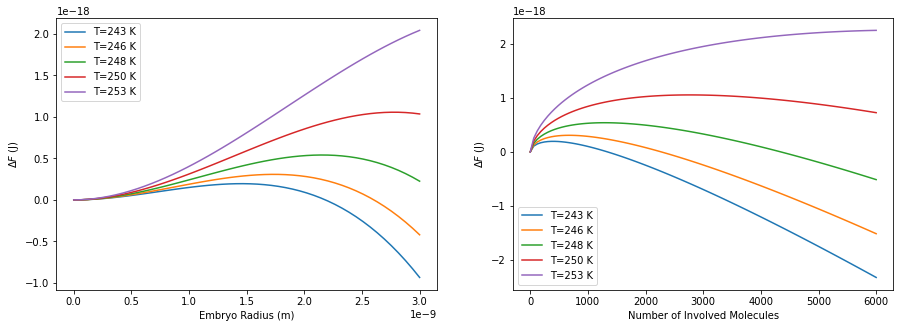

In [14]:
a = np.linspace(0, 3, 50) * 1e-9  # radius of cluster
n = np.linspace(0, 6000, 100)  # number of molecules in a cluster
temps = np.linspace(243, 253, 5)  # K
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for temp in temps:
    ax[0].plot(a, delF(temp, a), label=f"T={round(temp)} K")
    ax[1].plot(n, new_delF(temp, n), label=f"T={round(temp)} K")

ax[0].legend()
ax[0].set_xlabel("Embryo Radius (m)")
ax[0].set_ylabel("$\Delta F$ (J)")
ax[1].legend()
ax[1].set_xlabel("Number of Involved Molecules")
ax[1].set_ylabel("$\Delta F$ (J)");

If I've done this right, these plots should be exactly equivalent, but with different scales (number of molecules involved is proportional to radius cubed). The peaks of each plot appear to be in roughly the same spots as part 1 so I'll assume this worked for now.

However, this is the energy to construct the whole embryo, what we actually want is the energetic contribution from each individual molecule towards an embryo. For that we just divide by $n$

$$
\frac{\Delta F}{n} = -k_bTln(S) + \left(\frac{36\pi\nu_{mole}^2}{n}\right)^{\frac{1}{3}}\sigma
$$

In [15]:
# reassign delF function again
def new2_delF(T, n):
    """
    Computes the free energy per molecule added to an embryo of size n
    """
    F = -kb * T * np.log(S_iw(T)) + (36 * np.pi * v_mole_i ** 2 / n) ** (
        1 / 3
    ) * sig_iw(T) 
    return F

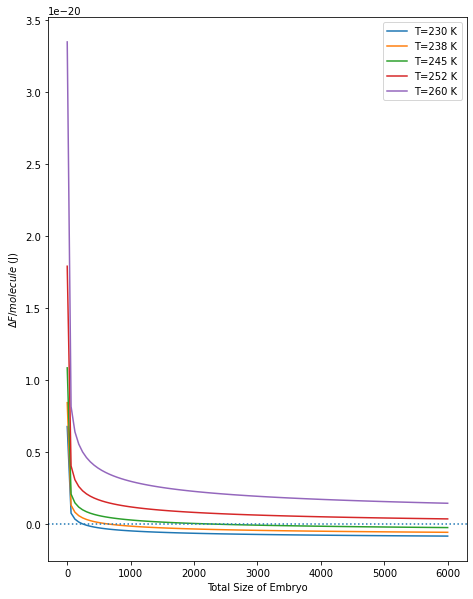

In [16]:
temps = np.linspace(230,260,5)
n = np.linspace(1, 6000, 100)  # number of molecules in a cluster

fig, ax = plt.subplots(figsize=(7.5, 10))
for temp in temps:
    ax.plot(n, new2_delF(temp, n), label=f"T={round(temp)} K")

ax.legend()
ax.set_xlabel("Total Size of Embryo")
ax.set_ylabel("$\Delta F/molecule$ (J)")
ax.axhline(y=0, ls=":");

Cool result! This shows how it is much easier to add the last few molecules to the embryo than the first ones, because the SA:V ratio keeps getting more favorable with larger embryos. The zero crossings of each curve represent the critical number for nucleation. Notice how many fewer you need at 230k than at 260, so homogeneous nucleation is much more likely at cold temperatures (surprise!)

Let's test our new "normalized" Boltzmann distribution, for a very simple system where clusters can only vary between 1 and $N$ molecules. Important note, this expression for $Z$ is a ridiculously bad guess, it only calculates the probability that a molecule is willing to change it's energy to form that of an n-cluster, and makes no attempt to figure out the probability that such high energy molecules find one another. (see *degeneracy* of a state for further details). This equation is almost guaranteed to underestimate the probability of low energy states and overestimate high energy states, but it might be better than Wang's 7.19 the way we used it in CMP. 

We will also truncate the series at $N=n_{crit}$, because states beyond the energy barrier aren't accessible until a state at the very top is reached. This isnt too sinful because the probability series decreases with increasing $\Delta F$, that is to say that the critical cluster is literally the least likely thing that could possibly happen, with a probability suitably close to zero that we can say the series "converges" there.


$$
P(s_i) = \frac{e^{\frac{-\Delta F_i}{k_bT}}}{\sum_{n=1}^{N} e^{\frac{-\Delta F_n}{k_bT}}} 
$$

Remember, we need $i$ molecules in state $s_i$ to form a cluster of size $n=i$. Capiche? Right now all I want to see is probabilities between 0 and 1 for the tiny system.

In [45]:
def P_si(s_i, n_max, T, ptuner=1):
    """
    outputs a probability of a particle in state s_i (ie a component of an i-mer),
    normalized to a partition function that goes out to n_max (which should be the critical i-mer number)
    """
    # compute the partition function
    Z = 0
    for n in np.linspace(1, n_max, n_max):
        Z += np.exp(new2_delF(T,n) / (kb * T))
        
    # do the boltzmann dist    
    P = np.exp(new2_delF(T, s_i) / (kb * T)) / (ptuner*Z) # leave myself a tuning parameter to fit stuff with 
    return P

In [46]:
# check to see that the sum of all possible states is 1 (allow some rounding error)
# norm should always be 1.0 or 0.9999...
norm = 0
Nmax = 10
temp = 130 # K
for i in np.linspace(1,Nmax,Nmax):
    P = P_si(i,Nmax,temp)
    norm += P
    print(P)
print(f'norm = {norm}')

0.0
0.0
6.368079142583423e-103
1.1828275918758858e-74
1.611991222101498e-54
3.8214860492771756e-39
7.44802855162432e-27
1.04540215567165e-16
4.003801494248707e-08
0.999999959961985
norm = 1.0


Forward progress! With $P(s_i)$ behaving well, we should now redefine the critical radius function from before, re-casting it in terms of critical number of molecules. Use the equation higher up (i really should add equation tags eh..) that still contains the factors of $n$ in both terms. Differentiate that wrt $n$ and set to zero to find the maxima:

$$
\Delta F = -nk_bTln(S) + \left(36\pi n^2\nu_{mole}^2\right)^{\frac{1}{3}}\sigma
$$

$$
\frac{\partial F}{\partial n} = -k_bTln(S) + \frac{2}{3}n^{\frac{-1}{3}}\left(36\pi\nu_{mole}^2\right)^{\frac{1}{3}}\sigma = 0
$$

$$
n_c = \frac{(24\pi\nu_{mole}^2)\sigma^3}{(k_bTln(S))^3}
$$


In [19]:
def N_crit(T):
    '''
    determines the critical number of molecules/embryo given temp T
    '''
    n_c = (24 * np.pi * v_mole_i ** 2 * sig_iw(T) ** 3) / (kb * T * np.log(S_iw(T))) ** 3 
    return n_c

Quickly check that this calculation works (i f*$d it up the first time), plot the critical radius on those same figures as before:

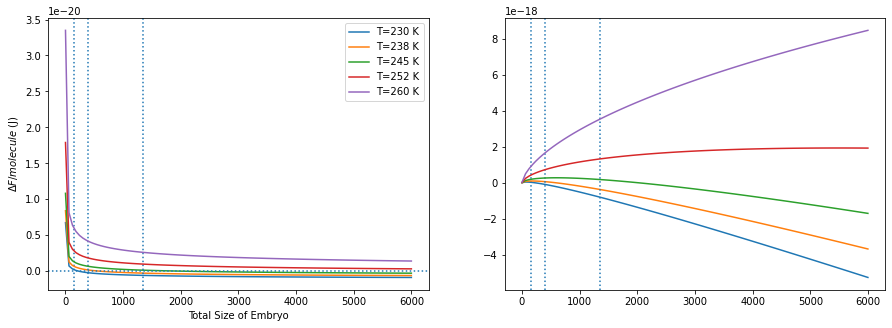

In [20]:
temps = np.linspace(230,260,5)
n = np.linspace(1, 6000, 100)  # number of molecules in a cluster

fig, ax = plt.subplots(1,2,figsize=(15, 5))
for temp in temps:
    ax[0].plot(n, new2_delF(temp, n), label=f"T={round(temp)} K")
    ax[1].plot(n, new_delF(temp, n), label=f"T={round(temp)} K")
    if N_crit(temp) < 6000:
        ax[0].axvline(x=N_crit(temp),ls=":")
        ax[1].axvline(x=N_crit(temp),ls=":")
        
    
ax[0].legend()
ax[0].set_xlabel("Total Size of Embryo")
ax[0].set_ylabel("$\Delta F/molecule$ (J)")
ax[0].axhline(y=0, ls=":");

Nice! Ok, almost there. We have the probability of finding a molecule willing to create a cluster of size $n$, but we want to know how many clusters exist in a unit volume of solution.

$$
concentration = probability \times volume
$$

remember that one kids... So we modify our $P(s_i)$ expression to include a prefactor with the initial number of molecules present $N_0$ and then divide $P(s_i)$ by $i$. We will (boldly) assume that if we can find $n$ molecules willing to form an embryo, that they will all find each other. (This is in actuality, extremely untrue, but less wrong than before perhaps). So the probability of finding an ice embryo of size $i$ is:

$$
N(i) = N_0 P(s_i)^i
$$

Now we really just repeat the analysis from before and see what happens with the new parameterization.

In [21]:
def N_i(i,T,N_0,ptuner=1):
    '''
    i - number of molecules involved in cluster
    T - the temperature
    N_0 - number of molecules in system
    
    returns: the number of i-mers of size i given temperature in a population of N_0 water molecules
    '''
    N_i = N_0 * P_si(i, N_0, T, ptuner=ptuner) / i
    return N_i

C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


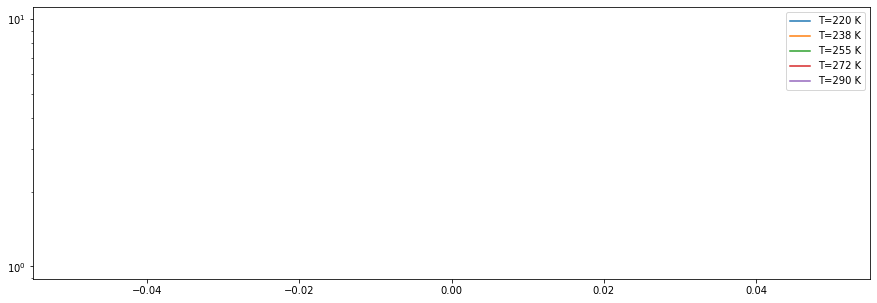

In [22]:
# plot number of embryos of size
temps = np.linspace(220, 290, 5)
N_0 = 100000
i = np.linspace(1,N_0,N_0)
fig, ax = plt.subplots(figsize=(15, 5))
for temp in temps:
    ax.plot(i, N_i(i,temp,N_0), label=f"T={round(temp)} K")
ax.set_yscale('log') 
ax.legend();

Just as I hoped! sustained, low probability existence of large-ish clusters! My model traverses 30 orders of magnitude instead of 200 as per the previous attempt. There is also a much weaker temperature dependence than before also, which miiiight support my T_ramp theory

This is working brilliantly. There is a large, relatively temperature insensitive range that only varies by $10^{15}$. in the atmospherically relevant range. Let's figure out the time dependence for 10$\mu m$ droplets again!

$$
J = K\cdot N_{i,critical}
$$

Where we calculate $N_{i,critical}$ for droplets of specified volume, they will freeze at a rate:

$$
N_{frz} = N_{start}(1-e^{-Jt})
$$

or calculate $t_{50}$ with:

$$
t = \frac{-ln(1/2)}{J}
$$

In [23]:
# how many molecules in a 10um droplet?
rad = 10e-6  # m
vol = 4 / 3 * np.pi * rad ** 2 # m3
nmcls = int(vol / v_mole_w)

In [24]:
N_i(N_crit(220),260,100)

C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


inf

C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


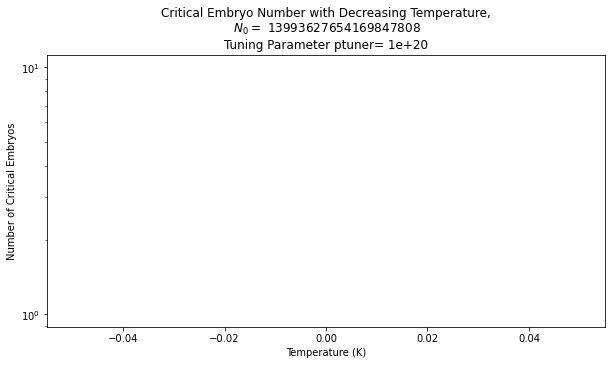

In [25]:
ptuner=1e20 # tuning parameter representing how hard it is for high energy molecules to find one another
temp = np.linspace(220,250,100)
N_icritical = N_i(N_crit(temp),temp,1,ptuner=ptuner) # relevant numbers of molecules are too big for python. calculate it for 1 molecule and multiply!
N_icritical *= nmcls

# do the same plot again for the r=10um drop
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(temp, N_icritical)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Number of Critical Embryos')
ax.set_title(f"Critical Embryo Number with Decreasing Temperature,\n $N_0=$ {nmcls} \nTuning Parameter ptuner= {ptuner}")
ax.set_yscale('log')

Now let's take a shot at $K$, the 'jumping speed' which represents how fast the molecules in the droplet flicker from state to state as dictated by the Boltzmann distribution. We'll use it as a tuning parameter but lets first make a broad, order of magnitude guess. the speed of sound in water is 1482m/s, and water molecules sit a few angstroms apart (we could take the cuberoot of ```v_mole_w``` as a guess at the length scale).

In [26]:
c = 1482 # m/s
l = v_mole_w ** (1/3) # m

guess = c / l
print(guess)

4773044006752.208


So something on the order of $10^{12}$ would be a good guess at $K$ maybe... 

C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\

Text(0.5, 1.0, 'time for half the sample to freeze')

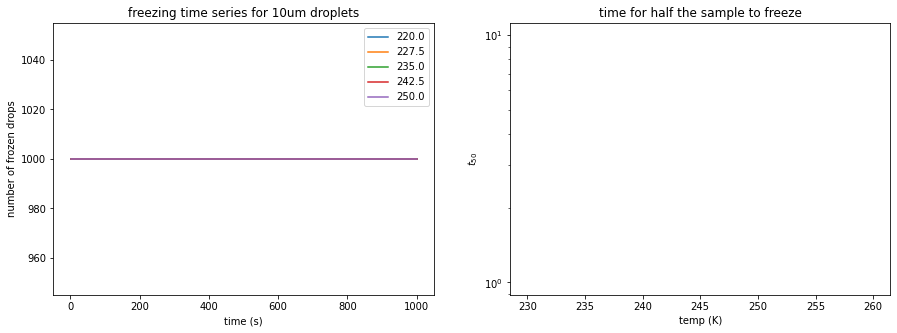

In [27]:
K = 4.70000
## Starting with 1000 droplets 10um radius, how long does it take to freeze?
N_start = 1000

ptuner = 1e20  # tuning parameter representing how hard it is for high energy molecules to find one another
temps = np.linspace(220, 250, 5)
time = np.linspace(0, 1000, 1000)

fig, ax = plt.subplots(1,2,figsize=(15,5))

# plot the time series
for temp in temps:
    N_icritical = N_i(
        N_crit(temp), temp, 1, ptuner=ptuner
    )  # relevant numbers of molecules are too big for python. calculate it for 1 molecule and multiply!
    N_icritical *= nmcls

    Nfrz = N_start * (1 - np.exp(-K * N_icritical * time))
    ax[0].plot(time, Nfrz, label=temp)    
    
ax[0].legend()
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('number of frozen drops')
ax[0].set_title('freezing time series for 10um droplets');

temp=np.linspace(260,230,100)
t_50 = -np.log(0.5) / (K * nmcls * N_i(N_crit(temp), temp, 1, ptuner=ptuner)) 
ax[1].plot(temp,t_50)
ax[1].set_xlabel('temp (K)')
ax[1].set_ylabel('$t_{50}$')
ax[1].set_yscale('log')
ax[1].set_title('time for half the sample to freeze')

modulating $K$ and ```ptuner``` seem to have the same effect...
ok, moment of truth though, can we simulate the FINC blank run?

In [28]:
## sloppily copy and paste the code from the last FINC simulator
time = np.linspace(0, 2000, 2001)  # just over half an hour, one second resolution
n_frzinst = np.zeros_like(time) # create empty vectors to hold frozen droplet counts. note 
n_frztotal = np.zeros_like(time) # this is terribly done and not computationally stable. fix in v2

#rad = 10e-7  # m
#wellvol = 4 / 3 * np.pi * rad ** 3

wellvol = 10e-6  # 10 microliter sample wells

n_0 = 288
for t in range(len(time)):
    temp = 273.15 - 1 / 60 * time[t]
    n_frzinst[t] = nfrz(n_0, wellvol, temp, time[t])
    n_frztotal[t] = n_frztotal[t - 1] + n_frzinst[t]
    n_0 -= n_frzinst[t]

TypeError: N_crit() takes 1 positional argument but 2 were given